<font size=6> <b> SMU Lab Three - MSDS7331 - Machine Learning-1 </b> </font>

<font size=5> <b> Summer 2020 Group - Sachin, Ikenna, Edgar, Dustin </b></font> 




<img src="https://github.com/sachinac/ML7331/blob/master/data/maxresdefault.png?raw=true" alt="Recommender" border="4"> 
<div align="center"> Image Source : Google Images </div>
<p align="center"><font size=5> <b> Movie Recommender System  </b></font> </p>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1">Import Libraries</a></span></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2">Introduction</a></span></li><li><span><a href="#Business-Understanding" data-toc-modified-id="Business-Understanding-3">Business Understanding</a></span></li><li><span><a href="#Data-Understanding-1" data-toc-modified-id="Data-Understanding-1-4">Data Understanding 1</a></span><ul class="toc-item"><li><span><a href="#Data-source" data-toc-modified-id="Data-source-4.1">Data source</a></span></li><li><span><a href="#Data-Description-Summary" data-toc-modified-id="Data-Description-Summary-4.2">Data Description Summary</a></span></li><li><span><a href="#Download-from-AWS-S3:" data-toc-modified-id="Download-from-AWS-S3:-4.3">Download from AWS S3:</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-4.4">Load Data</a></span></li><li><span><a href="#Get-the-glimpse-of-the-data" data-toc-modified-id="Get-the-glimpse-of-the-data-4.5">Get the glimpse of the data</a></span><ul class="toc-item"><li><span><a href="#Credits" data-toc-modified-id="Credits-4.5.1">Credits</a></span></li><li><span><a href="#Keywords" data-toc-modified-id="Keywords-4.5.2">Keywords</a></span></li><li><span><a href="#Movies-Metadata" data-toc-modified-id="Movies-Metadata-4.5.3">Movies Metadata</a></span></li><li><span><a href="#Movie-ratings" data-toc-modified-id="Movie-ratings-4.5.4">Movie ratings</a></span></li><li><span><a href="#Links" data-toc-modified-id="Links-4.5.5">Links</a></span></li></ul></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-4.6">Data Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Movie-Credits" data-toc-modified-id="Movie-Credits-4.6.1">Movie Credits</a></span></li><li><span><a href="#Movie-Keywords" data-toc-modified-id="Movie-Keywords-4.6.2">Movie Keywords</a></span></li><li><span><a href="#Movie-Metadata" data-toc-modified-id="Movie-Metadata-4.6.3">Movie Metadata</a></span></li><li><span><a href="#Movie-Ratings" data-toc-modified-id="Movie-Ratings-4.6.4">Movie Ratings</a></span></li></ul></li><li><span><a href="#Descriptive-Statistics-Summary" data-toc-modified-id="Descriptive-Statistics-Summary-4.7">Descriptive Statistics Summary</a></span><ul class="toc-item"><li><span><a href="#Credits/Keyword-Stats-Summary" data-toc-modified-id="Credits/Keyword-Stats-Summary-4.7.1">Credits/Keyword Stats Summary</a></span></li><li><span><a href="#Ratings-Stats-Summary" data-toc-modified-id="Ratings-Stats-Summary-4.7.2">Ratings Stats Summary</a></span></li><li><span><a href="#Movies-MetaData-Stats-Summary" data-toc-modified-id="Movies-MetaData-Stats-Summary-4.7.3">Movies MetaData Stats Summary</a></span></li></ul></li></ul></li><li><span><a href="#Data-Understanding-2---Visualization" data-toc-modified-id="Data-Understanding-2---Visualization-5">Data Understanding 2 - Visualization</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Movie-Popularity-distribution" data-toc-modified-id="Movie-Popularity-distribution-5.0.1">Movie Popularity distribution</a></span></li><li><span><a href="#Top-10-Stats:" data-toc-modified-id="Top-10-Stats:-5.0.2">Top 10 Stats:</a></span></li></ul></li></ul></li><li><span><a href="#Modeling-and-Evaluation-1" data-toc-modified-id="Modeling-and-Evaluation-1-6">Modeling and Evaluation 1</a></span><ul class="toc-item"><li><span><a href="#Basic-Explicit-Model-(user-item)" data-toc-modified-id="Basic-Explicit-Model-(user-item)-6.1">Basic Explicit Model (user-item)</a></span></li></ul></li><li><span><a href="#Modeling-and-Evaluation-2" data-toc-modified-id="Modeling-and-Evaluation-2-7">Modeling and Evaluation 2</a></span></li><li><span><a href="#Modeling-and-Evaluation-3" data-toc-modified-id="Modeling-and-Evaluation-3-8">Modeling and Evaluation 3</a></span></li><li><span><a href="#Modeling-and-Evaluation-4" data-toc-modified-id="Modeling-and-Evaluation-4-9">Modeling and Evaluation 4</a></span></li><li><span><a href="#Deployment" data-toc-modified-id="Deployment-10">Deployment</a></span></li><li><span><a href="#Exceptional-Work" data-toc-modified-id="Exceptional-Work-11">Exceptional Work</a></span></li><li><span><a href="#References" data-toc-modified-id="References-12">References</a></span></li></ul></div>

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import turicreate as tc
import ast
import wget
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MultiLabelBinarizer
from wordcloud import WordCloud, STOPWORDS

timebreak = '\n\n----------------------------------------------------\nCell Processing Time'

# Introduction

<i> "A recommender system calculates and provides relevant content to the user based on knowledge of the user, content, and interactions between the user and the item." </i> - Practical Recommeder Systems by Kim Falk 

<b> What are recommender Systems ? </b>

Systems that are designed to predict user's interests and recommend product items that are likely interesting for them. These are most powerful system particularly for online retailers to boost sales. E-commerce and retail companies are leveraging power of data and boosting sales by implementing recommender systems on their websites. The use cases of these systems have been steadily increasing within the last few years.

Companies like Amazon, Netflix, Linkedin, and Pandora leverage recommender systems to help users discover new and relevant items (products, videos, jobs, music), creating a delightful user experience while driving incremental revenue. The purpose of recommender systems is to tempt/persuade customer to buy a product/service by providing relevant information that interest to them right at their fingretips.

Recommendations typically speed up searches and make it easier for users to access content they’re interested in, and surprise them with offers they would have never searched for.

What is more, companies are able to gain and retain customers by sending out emails with links to new offers that meet the recipients’ interests, or suggestions of films and TV shows that suit their profiles.The user starts to feel known and understood and is more likely to buy additional products or consume more content. By knowing what a user wants, the company gains competitive advantage and the threat of losing a customer to a competitor decreases.

Providing that added value to users by including recommendations in systems and products is appealing. Furthermore, it allows companies to position ahead of their competitors and eventually increase their earnings.

Various types of recommendations systems are depcited in below diagram.<br><br>

  <div class="image1" align="center">
  <img src="https://d1m75rqqgidzqn.cloudfront.net/wp-data/2019/11/19121357/types-of-recommendation-systember.jpg" width="400" height="300" alt="Screen 1"/>
    <a href="https://d1m75rqqgidzqn.cloudfront.net/wp-data/2019/11/19121357/types-of-recommendation-systember.jpg"> 
        Image Source </a>
  </div>
  

For this assignment we will focus on user based and item based system which are based on nearest neighbour.




# Business Understanding


In this notebook we aim to build movie recommendations system using Apple's <a href="https://apple.github.io/turicreate/docs/userguide/recommender/"> Turicreate </a> package.The system that we are going to build will go a but deeper than traditional grouplens movie ratings dataset.In this notebook, we will be utilizing the popular movies dataset comprised of 26 million movie ratings from the GroupLens website, but with additional augmented data from TMDB which provides details including more detailed movie metadata such as: cast, crew, budget, country, revenue, languages and plot keywords on approximately 45,000 movies released prior to August 2017.

We will explore various methods for recommending movies to users based on content based and collaborative filtering methods. <b> Because movie taste is highly subjective, it may prove difficult to measure the effectiveness of our algorithms, but we will capture Root Mean Square Errored (RMSE) to compare predicted vs actual ratings for items.</b> We will also look at precision and recall for per-user and per-item metrics, as well as calculating metrics in different ways such as by genre or country or origin.

Here is general overview movie recommender system.

In general recommendation systems consist of following components

<b>1) Candidate generation </b><br><br>
    Starts from potentially huge corpus to smaller subset of candidates. e.g Candidate generator in youtube reduces 
    billions of videos to hundred or thousands<br><br>
    
Following table shows two common candidate generation approaches.
    
<table>
  <tr>
    <th  style="text-align:center">Type </th>
    <th  style="text-align:center" width="100px">Definition</th>
    <th  style="text-align:center" width="100px">Example</th>
  </tr>
  <tr>
    <td style="text-align:left" width="100px">content-based filtering</td>
    <td style="text-align:left">Uses similarity between items to recommend items similar to what the user likes.</td>
    <td style="text-align:left">If user A watches two cute cat videos, then the system can recommend cute animal videos to that user.</td>
  </tr>
  <tr>
    <td style="text-align:left">collaborative filtering</td>
    <td style="text-align:left">Uses similarities between queries and items simultaneously to provide recommendations</td>
    <td style="text-align:left">If user A is similar to user B, and user B likes video 1, then the system can recommend video 1 to user A (even if user A hasn’t seen any videos similar to video 1).</td>
  </tr>
</table>

    
<b> 2)  Scoring </b> <br> <br>
Next, another model scores and ranks the candidates in order to select the set of items (on the order of 10) to display to the user. <br><br>

<b>3) Re-Ranking</b><br><br>
Finally, the system must take into account additional constraints for the final ranking. For example, the system removes items that the user explicitly disliked or boosts the score of fresher content. Re-ranking can also help ensure diversity, freshness, and fairness<br><br>




   
<font size=4> <b> Content based filtering </b> </font>

Content-based filtering uses item features (movie-metadata) to recommend other items similar to what the user likes, based on their previous actions or explicit feedback. Movie dataset that we have obtained contains only ratings as explicit feedback. There are no other user's action data available in this dataset.

So this filter does not involve other users. It only recommends based on what particular user likes and recommends item with similar content. e.g If user A likes comedy and action movies and user B also likes comedy but never watched action movies,collborative filter will recommend action movies to user B based on common comedy movies and later it may turn out that User B also likes action movies and he gets more recommendations on this list. 

<table>
    <tr>
  <td style="background-color: transparent;">
    <img src="https://github.com/sachinac/ML7331/blob/master/data/content_based_filter.png?raw=true" alt="Snow" style="height:30%;width:100%;text-align:left">
      <div style="text-align:center"> Content-Based Filter </div>
      <div style="text-align:center"> Image Source : Google Images </div>
    </td>
  <td style="background-color: none;">
    <img src="https://github.com/sachinac/ML7331/blob/master/data/collaborative_filter.png?raw=true" alt="Forest" style="height:25%;width:60%;text-align:left">
      <div style="text-align:center"> Collaborative Filter </div>
      <div style="text-align:center"> Image Source : Google Images </div>
  </td>
</tr>
</table>


<font size=4> <b> Collaborative Filtering </b> </font>

There are two types of collaborative filtering exist: <br>

<b>User Based collaborative filtering </b><br>

This type of filter is based on users’ ratings, and it will recommend movies that user hasn't watched yet, but users similar to us have, and like. To determine whether two users are similar or not, this filter considers the movies both of them watched and how they rated them. By looking at the items in common, this type of algorithm  predicts the rating of a movie for a user who hasn’t watched it yet, based on the similar users’ rating.

One of the challenge for this type of filter to work accurately is that it requires user's ratings and in real sense not all users rate the movie they watched.Some of them never rate movie. That poses challege to build effective recommender.

<b> Item based collaborative filtering </b><br>
   
This is another type of recommendation method which looks for similar items based on items users have already liked or consumed.Item-based collaborative filtering is a model-based algorithm for making recommendations. In the algorithm, the similarities between different items in the dataset are calculated by using one of a number of similarity measures, and then these similarity values are used to predict ratings for user-item pairs not present in the dataset. 

<b>Similarity Measures</b>

There are a number of different mathematical formulations that can be used to calculate the similarity between two items. As can be seen in the formulae below, each formula includes terms summed over the set of common users U.

Item-base collaborative filtering normally divided into two sub tasks:
    
1.Calculate similarity among the items:
    
* Cosine-Based Similarity
* Correlation-Based Similarity
* Adjusted Cosine Similarity
* 1-Jaccard distance
    
2.Calculation of Prediction:
* Weighted Sum
* Regression
    
The difference between User-Based Collaborative Filtering and this method is that, in this case, we directly pre-calculate the similarity between the co-rated items, skipping K-neighborhood search

<b> What is long tail ? </b>

Typically, there are very popular items that users interact with a lot and others that they don’t, which comprise what is known as the <font size=4 color="blue">Long Tail</font>. Recommender systems usually work pretty well on popular items, although that’s probably not very interesting to users as they most likely already know about them. The items in the Long Tail are the most interesting ones, because they may not be considered by the user at all if they aren’t recommended.

<img src="https://github.com/sachinac/ML7331/blob/master/data/long-tail.png?raw=true" alt="Snow" style="width:50%">
<div style="text-align:center"> Image Source : <a href="https://tryolabs.com/blog/introduction-to-recommender-systems/"> Tryolab Article </a> </div>


# Data Understanding 1

## Data source 

We have obtained dataset from <a href=https://www.kaggle.com/rounakbanik/the-movies-dataset>kaggle </a> These files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.


## Data Description Summary


Here is brief Summary of movielens data: 

<table>
  <tr>
    <th  style="text-align:left">Filename </th>
    <th  style="text-align:left" width="100px">Number of records</th>
    <th  style="text-align:center" width="100px">Description</th>
  </tr>
  <tr>
    <td style="text-align:left" width="100px">movies_metadata.csv</td>
    <td style="text-align:left"> 45,467 </td>
    <td style="text-align:left">The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.
      </td>
  </tr>
  <tr>
    <td style="text-align:left" width="100px">keywords.csv</td>
        <td style="text-align:left"> 46,420 </td>
    <td style="text-align:left">Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.
      </td>
  </tr>
  <tr>
    <td style="text-align:left" width="100px">credits.csv</td>
    <td style="text-align:left"> 45,504 </td>
    <td style="text-align:left">Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.
      </td>
  </tr>
  <tr>
    <td style="text-align:left" width="100px">links.csv</td>
    <td style="text-align:left"> 45,844 </td>
    <td style="text-align:left">The file that contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.
      </td>
  </tr>    
  <tr>
    <td style="text-align:left" width="100px">ratings.csv</td>
    <td style="text-align:left"> 26,024,290 </td>
    <td style="text-align:left">The file that contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.
      </td>
  </tr>        
  <tr>
    <td style="text-align:left" width="100px">links_small.csv</td>
    <td style="text-align:left"> 9000 </td>
    <td style="text-align:left">Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset
      </td>
  </tr>    
  <tr>
    <td style="text-align:left" width="100px">ratings_small.csv</td>
    <td style="text-align:left"> 100,000 </td>
    <td style="text-align:left"> The subset of 100,000 ratings from 700 users on 9,000 movies.</td>
  </tr>        
  
</table>

Due to its huge size we have uploaded this data to AWS S3 bucket as github requires paid subscription to store more than 100MB of data. This notebook downloads data from AWS S3 for processing as described in the next sections.

## Download from AWS S3:


Because the unzipped data is ~ 900mb, we've saved it in an AWS S3 bucket as a zip file.  We've added the movies data directory to our *.gitignore* file so it doesn't get picked up in github.  This chunk of code does the following:
* Check if the movie directory exists, create it if not, skip the step if so.  
* Checks files in the directory against expected files, if not found, download the zip file from AWS, extracts and deletes the downloaded zip file, then cleans up created variables.

In [2]:
%%time
movie_dir = './data/movies'
movie_zipfile = movie_dir + '/movies.zip'
expected_files = ['keywords.csv', 'credits.csv', 'ratings.csv', 'ratings_small.csv', 'links_small.csv', 'movies_metadata.csv', 'links.csv']
movie_data = 'https://ml7331.s3.us-east-2.amazonaws.com/3405_6663_bundle_archive.zip'

# If movie directory doesn't exist, create it
if not os.path.isdir(movie_dir):
    print('creating directory:', movie_dir)
    os.mkdir(movie_dir)

# If all expected files are not present, download a fresh copy of movie data:    
if not all(files in os.listdir(movie_dir) for files in expected_files):
    print('downloading files...')
    wget.download(movie_data, movie_zipfile)
    print('unzipping files...')
    with zipfile.ZipFile(movie_zipfile, 'r') as zip_ref:
        zip_ref.extractall(movie_dir)
    os.remove(movie_zipfile)
    
del movie_data, movie_zipfile, movie_dir, expected_files
print('Movie files are present!', timebreak)

Movie files are present! 

----------------------------------------------------
Cell Processing Time
CPU times: user 850 µs, sys: 2.23 ms, total: 3.08 ms
Wall time: 3.18 ms


## Load Data 

Let's first load data into memory

In [3]:
%%time

credits  = pd.read_csv('./data/movies/credits.csv')
keywords = pd.read_csv('./data/movies/keywords.csv')
movies   = pd.read_csv('./data/movies/movies_metadata.csv', low_memory=False)


links_small   = pd.read_csv('./data/movies/links_small.csv')
links         = pd.read_csv('./data/movies/links.csv')
ratings_small = pd.read_csv('./data/movies/ratings_small.csv')
ratings_full  = pd.read_csv('./data/movies/ratings.csv')


CPU times: user 7.87 s, sys: 2.06 s, total: 9.93 s
Wall time: 10.4 s


## Get the glimpse of the data

Here we will see structure of the data and first 5 records from each data file to get glimpse of the data.
Few fields are of type json and these fields needs to be processed in order to use these fields in model building process. In pandas these fields are stored as normal object so viewing first 5 record we can see contents of each data field to take appropriate actions that may be required for preprocessing.

### Credits

As we can see below cast and crew fields are looking like dictonary. These are json type.

In [4]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [5]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


### Keywords

Keywords field is of type dict/json

In [6]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


In [7]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


### Movies Metadata

Movies metadata following fields are dictionary/json :<br>
* belongs_to_collection
* genres
* production_companies
* production_countries
* spoken_languages 

In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [9]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


### Movie ratings

These are user interactions. It contains ratings given by user for the movie they watched.

In [10]:
ratings_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [11]:
ratings_full.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


### Links

Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Datas.

In [12]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45843 entries, 0 to 45842
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  45843 non-null  int64  
 1   imdbId   45843 non-null  int64  
 2   tmdbId   45624 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.0 MB


In [13]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


## Data Preprocessing

Programatically Identify duplicate records and eliminate them,transform json datatypes as described in below sections.

### Movie Credits

The credits dataset (found in /data/credits.csv) has a movie id column and provides two JSON objects stored as a string representing the crew and cast.  It uses single quotes for strings, except in cases where a single quote is used, these strings are wrapped in double quotes.  Well formed JSON expects strings to be wrapped in double quotes, so we'll write a little helper function using the *literal_eval* function from the Abstract Syntax Trees package.

After parsing them as literal into a list object, we can pick out **directors, producers and actors**, which we think will be most important in influencing recommendations.  We'll save these as list objects which we can then merge into our movies dataset.

We also discovered 44 duplicate entries in this file, which from a sample of random selections appear to be true duplicates and will be safely removed.

In [14]:
%%time

# Drop rows where both cast and crew are empty
credits = credits[~((credits['cast'].str.contains('\[\]')) & (credits['crew'].str.contains('\[\]')))]

def dedupe(df):
    dupes = len(df[df.duplicated(subset=['id'])])
    print('Removed', dupes, 'duplicate rows.\n')
    return df[~df.duplicated(subset=['id'])]

# Remove duplicates:
credits = dedupe(credits)

def get_credits(crew_json):
    crew = ast.literal_eval(crew_json.crew)
    cast = ast.literal_eval(crew_json.cast)
    directors = []
    producers = []
    actors = []
    for member in crew:
#        if member is np.nan:
#            member = '[]'
        if 'Director' in member['job'] and member['job'] is not np.nan:
            directors.append(member['name'])
        if 'Producer' in member['job'] and member['job'] is not np.nan:
            producers.append(member['name'])
    for actor in cast:
#        if actor is np.nan:
#            actor = '[]'
        if actor['name'] is not np.nan:
            actors.append(actor['name'])

    return  pd.Series([directors, producers, actors])

credits[['directors','producers','actors']] = credits.apply(get_credits, axis=1)

def make_dict(lst):
    if lst is np.nan:
        return np.nan
    else:
        return { i : 'name' for i in lst }
        #return {i:lst[i] for i in range(0, len(lst))}

credits['actors_dict'] = credits.actors.apply(make_dict)
credits['producers_dict'] = credits.producers.apply(make_dict)
credits['directors_dict'] = credits.directors.apply(make_dict)

print(credits.info(),timebreak)

credits.head()


Removed 44 duplicate rows.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45011 entries, 0 to 45475
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cast            45011 non-null  object
 1   crew            45011 non-null  object
 2   id              45011 non-null  int64 
 3   directors       45011 non-null  object
 4   producers       45011 non-null  object
 5   actors          45011 non-null  object
 6   actors_dict     45011 non-null  object
 7   producers_dict  45011 non-null  object
 8   directors_dict  45011 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.4+ MB
None 

----------------------------------------------------
Cell Processing Time
CPU times: user 52.3 s, sys: 694 ms, total: 53 s
Wall time: 53.3 s


,cast,crew,id,directors,producers,actors,actors_dict,producers_dict,directors_dict
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,"[John Lasseter, Ash Brannon, William Reeves, R...","[Bonnie Arnold, Ed Catmull, Ralph Guggenheim, ...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","{'Tom Hanks': 'name', 'Tim Allen': 'name', 'Do...","{'Bonnie Arnold': 'name', 'Ed Catmull': 'name'...","{'John Lasseter': 'name', 'Ash Brannon': 'name..."
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,"[Joe Johnston, Thomas E. Ackerman]","[Larry J. Franco, Scott Kroopf, Ted Field, Rob...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","{'Robin Williams': 'name', 'Jonathan Hyde': 'n...","{'Larry J. Franco': 'name', 'Scott Kroopf': 'n...","{'Joe Johnston': 'name', 'Thomas E. Ackerman':..."
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,[Howard Deutch],[],"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","{'Walter Matthau': 'name', 'Jack Lemmon': 'nam...",{},{'Howard Deutch': 'name'}
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,[Forest Whitaker],"[Ronald Bass, Ezra Swerdlow, Deborah Schindler...","[Whitney Houston, Angela Bassett, Loretta Devi...","{'Whitney Houston': 'name', 'Angela Bassett': ...","{'Ronald Bass': 'name', 'Ezra Swerdlow': 'name...",{'Forest Whitaker': 'name'}
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,"[Elliot Davis, Charles Shyer]",[Nancy Meyers],"[Steve Martin, Diane Keaton, Martin Short, Kim...","{'Steve Martin': 'name', 'Diane Keaton': 'name...",{'Nancy Meyers': 'name'},"{'Elliot Davis': 'name', 'Charles Shyer': 'name'}"


### Movie Keywords

The keywords dataset (found in /data/keywords.csv) has a movie id column and again provides a JSON object stored as a string representing keywords which apply to each movie.  It uses single quotes for strings, except in cases where a single quote is used, these strings are wrapped in double quotes.  Well formed JSON expects strings to be wrapped in double quotes, so we'll utilize another helper function using the *literal_eval* function from the Abstract Syntax Trees package.

After parsing them as literal into a list object, and removing empty list objects, we'll save these **plot keywords** as list object which we can merge into our movies dataset.

There are 532 duplicate entries in this file which from a sample of random selections, again appear to be true duplicates and will be safely removed.

In [15]:
%%time

#keywords = pd.read_csv('./data/movies/keywords.csv')

# Remove empty entries:
keywords = keywords[~keywords['keywords'].str.contains('\[\]')]

# Remove duplicates:
keywords = dedupe(keywords)

keywords['keyword_json'] = keywords['keywords'] 

# Breakout json into a list of names
def get_keywords(keyword_list):
    if keyword_list is np.nan:
        return np.nan
    kw = []
    klist = ast.literal_eval(keyword_list)
    for word in klist:
        kw.append(word['name'])
    return kw

keywords['keywords'] = keywords.keyword_json.apply(get_keywords)

print(keywords.info(),timebreak)

keywords.head()

Removed 532 duplicate rows.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31092 entries, 0 to 46415
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            31092 non-null  int64 
 1   keywords      31092 non-null  object
 2   keyword_json  31092 non-null  object
dtypes: int64(1), object(2)
memory usage: 971.6+ KB
None 

----------------------------------------------------
Cell Processing Time
CPU times: user 1.83 s, sys: 26.6 ms, total: 1.86 s
Wall time: 1.86 s


,id,keywords,keyword_json
0,862,"[jealousy, toy, boy, friendship, friends, riva...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[board game, disappearance, based on children'...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[fishing, best friend, duringcreditsstinger, o...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[based on novel, interracial relationship, sin...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[baby, midlife crisis, confidence, aging, daug...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


### Movie Metadata



The movies dataset (found in /data/movies_metadata.csv) has a movie id column and provides a lot of usable and JSON objects storing various metadata about each movie.  This dataset also appears to contain approximately 30 duplicate records, and after examining a sample of random selections, they appear to be true duplicates and will be safely removed.

In this section we'll accomplish the following:  
* There are three movies with improper ID values (1997-08-20,2012-09-29,2014-01-01), these items all appear to have incorrect formatting, so we'll drop these in order to merge the keyword and credits datasets and prevent future problems.
* Merge directors, producers and actors from credits dataset
* Merge keywords from keywords dataset
* Clean up the movie collection by converting it to a string, as it appears to only contain one item per movie.
* Convert the JSON genres object into a list of genres
* Add new field num_of_years from release (derived from release date)
* Change Data type of field "budget" and "popularity" from object to float64


In [16]:
%%time
def number_of_years(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return round(abs((d2 - d1).days)/365.0,1)

today = datetime.today().strftime("%Y-%m-%d")

#movies = pd.read_csv('./data/movies/movies_metadata.csv', low_memory=False)
print('Original Movies Shape: ', movies.shape, '\n')

# Remove the movies with erroneous data & convert ID to int:
movies = movies[~movies['id'].str.contains('-')]
movies['id'] = movies['id'].astype(int)

# Remove duplicates:
movies = dedupe(movies)

print('Movies Shape after dropping bad data: ', movies.shape, '\n')

# Add Keywords & Credits
movies = movies.merge(keywords, how='left', on='id')
print('Movies Shape after merging keywords: ', movies.shape, '\n')

movies = movies.merge(credits, how='left', on='id')
print('Movies Shape after merging credits: ', movies.shape, '\n')

movies = movies.drop(columns=['cast','crew','keyword_json'])

# Function to convert collection to a string
def get_collection(json):
    if pd.isnull(json):
        return np.nan
    else:
        return ast.literal_eval(json)['name']

movies['belongs_to_collection'] = movies.belongs_to_collection.apply(get_collection)

#preserve genres and spoken language dicts:
movies['genre_dict'] = movies['genres']
movies['spoken_languages_dict'] = movies['spoken_languages']
#We can re-use our get_keywords function here to get genres & spoken languages
movies['genres'] = movies.genres.apply(get_keywords)
movies['spoken_languages'] = movies.spoken_languages.apply(get_keywords)

#
#  We can check if a string is NaN by using the property of NaN object that a NaN != NaN.
#  y==y checks if given string is not an NaN. if NaN it will put undefined -1 
#
movies['number_of_years']  =  [ number_of_years(today,y) if y==y else -1 for y in movies['release_date']]

print(movies.info(),timebreak)
movies['budget']     = movies['budget'].astype('float64')
movies['popularity'] = movies['popularity'].astype('float64')

movies.head()


Original Movies Shape:  (45466, 24) 

Removed 30 duplicate rows.

Movies Shape after dropping bad data:  (45433, 24) 

Movies Shape after merging keywords:  (45433, 26) 

Movies Shape after merging credits:  (45433, 34) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45433 entries, 0 to 45432
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45433 non-null  object 
 1   belongs_to_collection  4488 non-null   object 
 2   budget                 45433 non-null  object 
 3   genres                 45433 non-null  object 
 4   homepage               7774 non-null   object 
 5   id                     45433 non-null  int64  
 6   imdb_id                45416 non-null  object 
 7   original_language      45422 non-null  object 
 8   original_title         45433 non-null  object 
 9   overview               44479 non-null  object 
 10  popularity             45430 non-null  o

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,keywords,directors,producers,actors,actors_dict,producers_dict,directors_dict,genre_dict,spoken_languages_dict,number_of_years
0,False,Toy Story Collection,30000000.0,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[jealousy, toy, boy, friendship, friends, riva...","[John Lasseter, Ash Brannon, William Reeves, R...","[Bonnie Arnold, Ed Catmull, Ralph Guggenheim, ...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","{'Tom Hanks': 'name', 'Tim Allen': 'name', 'Do...","{'Bonnie Arnold': 'name', 'Ed Catmull': 'name'...","{'John Lasseter': 'name', 'Ash Brannon': 'name...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'iso_639_1': 'en', 'name': 'English'}]",24.8
1,False,NaN,65000000.0,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[board game, disappearance, based on children'...","[Joe Johnston, Thomas E. Ackerman]","[Larry J. Franco, Scott Kroopf, Ted Field, Rob...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","{'Robin Williams': 'name', 'Jonathan Hyde': 'n...","{'Larry J. Franco': 'name', 'Scott Kroopf': 'n...","{'Joe Johnston': 'name', 'Thomas E. Ackerman':...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",24.7
2,False,Grumpy Old Men Collection,0.0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,"[fishing, best friend, duringcreditsstinger, o...",[Howard Deutch],[],"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","{'Walter Matthau': 'name', 'Jack Lemmon': 'nam...",{},{'Howard Deutch': 'name'},"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'iso_639_1': 'en', 'name': 'English'}]",24.6
3,False,NaN,16000000.0,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,"[based on novel, interracial relationship, sin...",[Forest Whitaker],"[Ronald Bass, Ezra Swerdlow, Deborah Schindler...","[Whitney Houston, Angela Bassett, Loretta Devi...","{'Whitney Houston': 'name', 'Angela Bassett': ...","{'Ronald Bass': 'name', 'Ezra Swerdlow': 'name...",{'Forest Whitaker': 'name'},"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'iso_639_1': 'en', 'name': 'English'}]",24.6
4,False,Father of the Bride Collection,0.0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,"[baby, midlife crisis, confidence, aging, daug...","[Elliot Davis, Charles Shyer]",[Nancy Meyers],"[Steve Martin, Diane Keaton, Martin Short, Kim...","{'Steve Martin': 'name', 'Diane Keaton': 'name...",{'Nancy Meyers': 'name'},"{'Elliot Davis': 'name', 'Charles Shyer': 'name'}","[{'id': 35, 'name': 'Comedy'}]","[{'iso_639_1': 'en', 'name': 'English'}]",25.5


### Movie Ratings

The ratings dataset consists of approximately **270,000 annonomous userIds, 45,000 movieIds that we can link to our movies dataset, and 2.6 million user ratings** on a scale from **0.5 - 5.0** (worst to best), and a timestamp for when the rating was collected. A cursory glance through the data shows there are no duplicate ratings for user/movie combinations, saving us the work of averaging the scores! Clean data FTW!

*ratings_small* is a subset of the ratings dataset available in the Full MovieLens dataset and contains about **100,000 ratings from 671 users on 9,066 movies**.

In [17]:
ratings_small = pd.read_csv('./data/movies/ratings_small.csv')

ratings_small.info()
print('\nCount of duplicate ratings for a user/movie:',len(ratings_small[ratings_small.duplicated(subset=['userId','movieId'])]))
print('\nNumber of unique movies:',len(ratings_small.movieId.unique()))
print('\nNumber of unique users:',len(ratings_small.userId.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB

Count of duplicate ratings for a user/movie: 0

Number of unique movies: 9066

Number of unique users: 671


In [18]:
ratings = pd.read_csv('./data/movies/ratings.csv')

ratings.info()
print('\nCount of duplicate ratings for a user/movie:',len(ratings[ratings.duplicated(subset=['userId','movieId'])]))
print('\nNumber of unique movies:',len(ratings.movieId.unique()))
print('\nNumber of unique users:',len(ratings.userId.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB

Count of duplicate ratings for a user/movie: 0

Number of unique movies: 45115

Number of unique users: 270896


## Descriptive Statistics Summary

Use preprocessed data to see how Mean,Median,Mode and other stats looks like using describe function.

### Credits/Keyword Stats Summary


Credits and Keywords set doesn't have categorical or numerical data. All fields are lists which can be used as additional information or side information during model building process. Turicreate internally creates Vector Embeddings to use them to find similarity between users/movies.

Cast Crew and keyword if absent in the data, we don't need to remove these rows, even if lists producers column is absent, other columns does contain important information for that particular record. So we are not deleting any records. Those missing will be handled by Turicreate internally.

In [19]:
keywords.head()

,id,keywords,keyword_json
0,862,"[jealousy, toy, boy, friendship, friends, riva...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[board game, disappearance, based on children'...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[fishing, best friend, duringcreditsstinger, o...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[based on novel, interracial relationship, sin...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[baby, midlife crisis, confidence, aging, daug...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [20]:
credits.head()

,cast,crew,id,directors,producers,actors,actors_dict,producers_dict,directors_dict
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,"[John Lasseter, Ash Brannon, William Reeves, R...","[Bonnie Arnold, Ed Catmull, Ralph Guggenheim, ...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","{'Tom Hanks': 'name', 'Tim Allen': 'name', 'Do...","{'Bonnie Arnold': 'name', 'Ed Catmull': 'name'...","{'John Lasseter': 'name', 'Ash Brannon': 'name..."
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,"[Joe Johnston, Thomas E. Ackerman]","[Larry J. Franco, Scott Kroopf, Ted Field, Rob...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","{'Robin Williams': 'name', 'Jonathan Hyde': 'n...","{'Larry J. Franco': 'name', 'Scott Kroopf': 'n...","{'Joe Johnston': 'name', 'Thomas E. Ackerman':..."
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,[Howard Deutch],[],"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","{'Walter Matthau': 'name', 'Jack Lemmon': 'nam...",{},{'Howard Deutch': 'name'}
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,[Forest Whitaker],"[Ronald Bass, Ezra Swerdlow, Deborah Schindler...","[Whitney Houston, Angela Bassett, Loretta Devi...","{'Whitney Houston': 'name', 'Angela Bassett': ...","{'Ronald Bass': 'name', 'Ezra Swerdlow': 'name...",{'Forest Whitaker': 'name'}
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,"[Elliot Davis, Charles Shyer]",[Nancy Meyers],"[Steve Martin, Diane Keaton, Martin Short, Kim...","{'Steve Martin': 'name', 'Diane Keaton': 'name...",{'Nancy Meyers': 'name'},"{'Elliot Davis': 'name', 'Charles Shyer': 'name'}"


### Ratings Stats Summary
Ratings file contains only rating column on which we can take summary. We don't need to take summary on userId and movieId as these are ID columns. 

<font size=4> <b> outliers </b> </font><br><br>
As we can see from the boxplot there are few observation beyond whiskers. these are outliers and may influence the predictions on rating. This is huge dataset and percentage of outliers is very less therefore we have decided to remove these outliers.

In [21]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


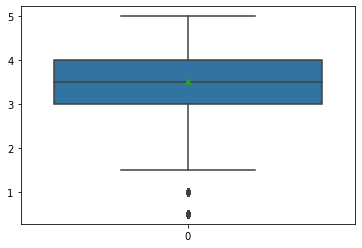

In [22]:
ax = sns.boxplot(data=ratings['rating'],showmeans=True)

<font size=4> <b> Remove outliers </b> </font><br><br>

In [23]:
print('Before ',ratings.shape)

Q1 = ratings.quantile(0.25)
Q3 = ratings.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
ratings_final = ratings[~((ratings < (Q1 - 1.5 * IQR)) |(ratings > (Q3 + 1.5 * IQR))).any(axis=1)].copy().reset_index()
print('After ',ratings_final.shape)
print('Removed count ',ratings.shape[0]-ratings_final.shape[0])

Before  (26024289, 4)
userId          135529.0
movieId           5430.0
rating               1.0
timestamp    366823318.0
dtype: float64
After  (20069486, 5)
Removed count  5954803


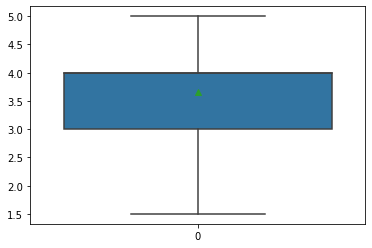

In [24]:
ax = sns.boxplot(data=ratings_final['rating'],showmeans=True)

### Movies MetaData Stats Summary

Movies dataset has following numberic fields:<br>

* budget
* popularity
* revenue
* runtime
* vote_average
* vote_count
* number_of_years (New derived field from release date)

All other fields are either ID fields or list/dictionaries, So for now we don't need to look at those to check outliers. 

First of all check if any of the records has NaN. We need to remove these records as model will fail due to NaN. We don't know why these numbers are missing, We don't prefer imputing here as count is small compared to 45K movies, only 260 are seems to NaN. Therefore we will remove these records.    



<font size="3"> <b> Remove NaNs </b> </font> <br>
Here is count NaN rows that needs to be deleted. We don't see any suspcious outlier in these fields and therefore we will keep records as it is after removing NaNs

In [25]:
print('Shape Before',movies.shape)

print(movies.loc[:,['budget','title','popularity','revenue',
                    'number_of_years','runtime','vote_average','vote_count'] ].isnull().sum())

#movies[movies.loc[:,['budget','title','popularity',
#                                                                      'revenue','number_of_years','runtime',
#                                                                      'vote_average','vote_count'] ].isna().any(axis=1)]

movies_final= movies.dropna(subset=['budget','title','popularity','revenue',
                      'number_of_years','runtime','vote_average','vote_count']).copy()
print('Shape After',movies_final.shape)
print('\n')
print('Total Deleted',movies.shape[0]-movies_final.shape[0])

Shape Before (45433, 34)
budget               0
title                3
popularity           3
revenue              3
number_of_years      0
runtime            260
vote_average         3
vote_count           3
dtype: int64
Shape After (45173, 34)


Total Deleted 260


In [26]:
movies_final.sort_values(by=['popularity'],ascending=False).head(10).loc[:,['budget','title','popularity',
                                                                     'revenue','number_of_years','runtime',
                                                                      'vote_average','vote_count' ]]

,budget,title,popularity,revenue,number_of_years,runtime,vote_average,vote_count
30677,74000000.0,Minions,547.488298,1.156731e+09,5.1,91.0,6.4,4729.0
33333,149000000.0,Wonder Woman,294.337037,8.205804e+08,3.2,141.0,7.2,5025.0
42192,160000000.0,Beauty and the Beast,287.253654,1.262886e+09,3.4,129.0,6.8,5530.0
43614,34000000.0,Baby Driver,228.032744,2.245113e+08,3.1,113.0,7.2,2083.0
24438,165000000.0,Big Hero 6,213.849907,6.521054e+08,5.8,102.0,7.8,6289.0
26546,58000000.0,Deadpool,187.860492,7.831130e+08,4.5,108.0,7.4,11444.0
26548,200000000.0,Guardians of the Galaxy Vol. 2,185.330992,8.634161e+08,3.3,137.0,7.6,4858.0
14546,237000000.0,Avatar,185.070892,2.787965e+09,10.7,162.0,7.2,12114.0
24334,20000000.0,John Wick,183.870374,8.876166e+07,5.8,101.0,7.0,5499.0
23658,61000000.0,Gone Girl,154.801009,3.693304e+08,5.9,145.0,7.9,6023.0


In [27]:
movies_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45173 entries, 0 to 45432
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45173 non-null  object 
 1   belongs_to_collection  4480 non-null   object 
 2   budget                 45173 non-null  float64
 3   genres                 45173 non-null  object 
 4   homepage               7773 non-null   object 
 5   id                     45173 non-null  int64  
 6   imdb_id                45158 non-null  object 
 7   original_language      45162 non-null  object 
 8   original_title         45173 non-null  object 
 9   overview               44476 non-null  object 
 10  popularity             45173 non-null  float64
 11  poster_path            44814 non-null  object 
 12  production_companies   45173 non-null  object 
 13  production_countries   45173 non-null  object 
 14  release_date           45100 non-null  object 
 15  re

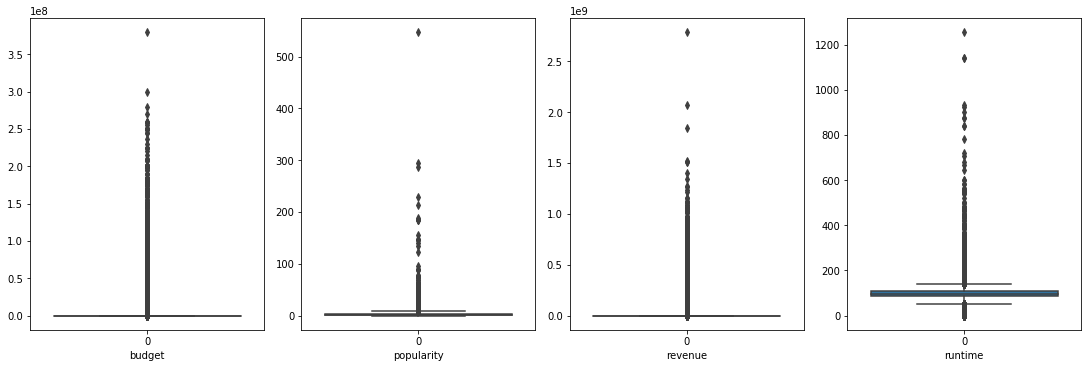

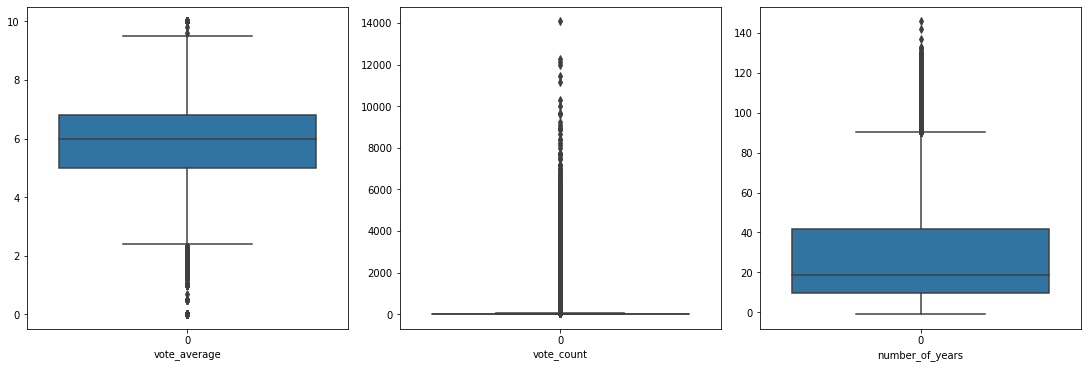

In [28]:
from sklearn.preprocessing import scale
fig, ax =plt.subplots(1,4, constrained_layout=True,figsize=(15,5))

ax[0].set(xlabel='budget')
sns.boxplot(data = movies_final['budget']    ,ax=ax[0])
ax[1].set(xlabel='popularity')
sns.boxplot(data = movies_final['popularity'],ax=ax[1])
ax[2].set(xlabel='revenue')
sns.boxplot(data = movies_final['revenue']   ,ax=ax[2])
ax[3].set(xlabel='runtime')
sns.boxplot(data = movies_final['runtime']   ,ax=ax[3])


fig, ax =plt.subplots(1,3, constrained_layout=True,figsize=(15,5))
ax[0].set(xlabel='vote_average')
sns.boxplot(data = movies_final['vote_average']    ,ax=ax[0])
ax[1].set(xlabel='vote_count')
sns.boxplot(data = movies_final['vote_count']      ,ax=ax[1])
ax[2].set(xlabel='number_of_years')
sns.boxplot(data = movies_final['number_of_years'] ,ax=ax[2])

<font color="red"> We do see outliers. But this is expected as few movies are very popular with very high budget compared to others therefore we won't take any actions on the remaining dataset </font>

# Data Understanding 2 - Visualization

Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

### Movie Popularity distribution

Long tail does exist as expected. Few movies are very popular and mostly watched and rated while few are rarely watched or never watched or rated by users.

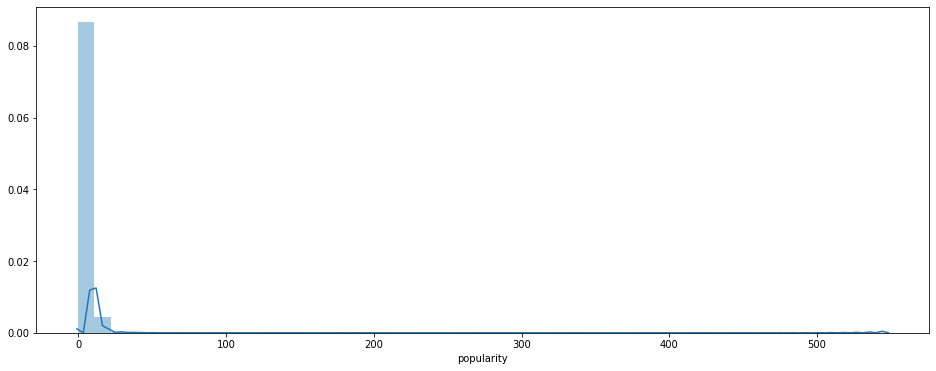

In [29]:
%matplotlib inline
plt.figure(figsize=(16, 6))
ax = sns.distplot(movies_final['popularity'],hist=True, rug=False)
    

Plotting the rating distribution shows some bias towards higher ratings, this could be due to users feeling more passionately about a great movie than a mediocre one, or that users are more likely to seek out, view and subsequently rate high-rated movies.

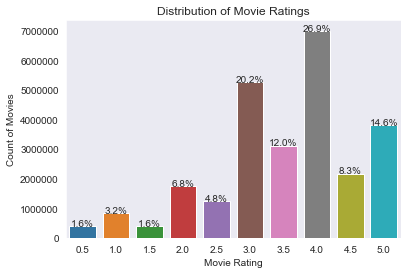

In [30]:
# Ratings Histogram:
sns.set_style("dark")
ax = sns.countplot(x="rating", data=ratings)
total = float(len(ratings))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 3,
            '{0:.1%}'.format(height/total),
            ha="center") 
ax.set_ylabel("Count of Movies")
ax.set_xlabel("Movie Rating")
ax.set_title("Distribution of Movie Ratings")
plt.show()

Examining the distribution of movie genre could be useful if we decide to get more sophisticated with our recommendation engine, if we branch out of user preferences (or if we're recommending to a new user), we might try to keep the movie recommendations in line with the overall genre distribution.

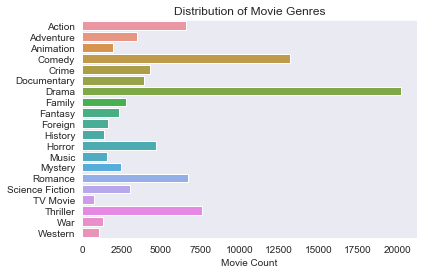

In [31]:
mlb = MultiLabelBinarizer()
genre_count = pd.DataFrame(mlb.fit_transform(movies['genres']),columns=mlb.classes_).sum()

ax = sns.barplot(genre_count.values, genre_count.index)
ax.set_xlabel("Movie Count")
ax.set_title("Distribution of Movie Genres")
plt.show()

The distribution of votes on each movie indicates that more users are willing to rate movies at a 0 than a 10, and the distribution is slightly left skewed, indicating users may be more likely to rate movies using the higher end of the scale.

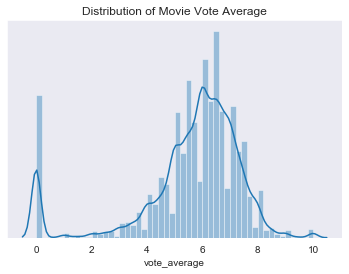

In [32]:
ax = sns.distplot(movies['vote_average'])
ax.set_ylabel("")
ax.set_yticks([])
ax.set_title("Distribution of Movie Vote Average")
plt.show()


Below is a word cloud for the common keywords found in the movies dataset.

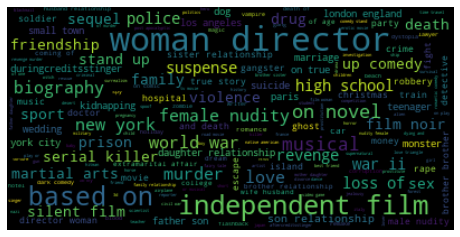

In [33]:
# Code adapted from: https://github.com/amueller/word_cloud/blob/master/examples/simple.py
l = keywords['keywords'].values.tolist()

text = []
for sublist in l:
    for item in sublist:
        text.append(item)
        
text = ' '.join(text)

wordcloud = WordCloud(max_font_size=30).generate(text)
plt.figure(figsize=(8,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


### Top 10 Stats:
Below we'll list several top 10 statistics for movies.  For the most part, the stats will be the top 10 "blank" having the most movies.  The only exception to this is the top 10 movies by vote count.  The ordering is as follows:
* Actors with the most movies
* Genres with the most movies
* Directors with the most movies
* Producers with the most movies
* Collections with the most movies
* Original Languages with the most movies
* Spoken Languages with the most movies
* Highest rated movies by TMDB user votes (movies must have at least 1,000 votes)

In [34]:
def get_top10_list(column, plot=True):
    mlb = MultiLabelBinarizer()
    if type(movies[column][0]) == list:
        top10 = pd.DataFrame(mlb.fit_transform(movies[movies[column].str.len() > 0][column]),columns=mlb.classes_).sum().nlargest(n=10)
    else:
        top10 = movies[movies[column].str.len() > 0][column].value_counts().nlargest(10)
    ax = sns.barplot(top10.values, top10.index)
    ax.set_xlabel("Movie Count")
    ax.set_title("Top 10 {} by Movie Count".format(column.capitalize()))
    total = float(len(movies))
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/1.5
            ax.annotate(percentage, (x, y))
    if plot:
        return plt.show()
    plt.close()
    return top10

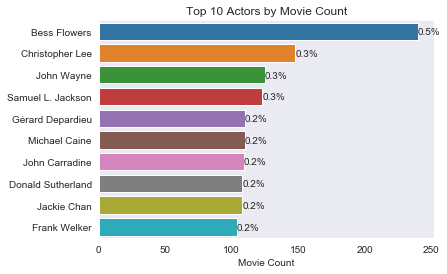

In [35]:
get_top10_list('actors')

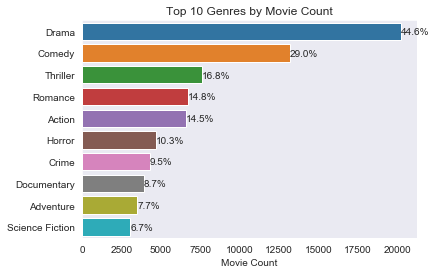

In [36]:
get_top10_list('genres')

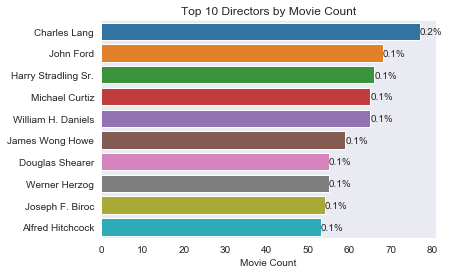

In [37]:
get_top10_list('directors')

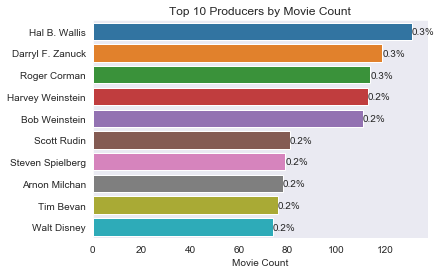

In [38]:
get_top10_list('producers')

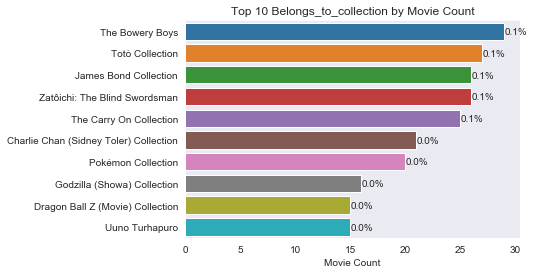

In [39]:
get_top10_list('belongs_to_collection')

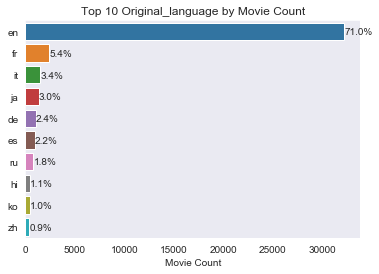

In [40]:
get_top10_list('original_language')

In [41]:
print('Top 10 Spoken Languages by Movie Count')
pd.DataFrame(get_top10_list('spoken_languages', plot=False), columns=['Movie Count'])

Top 10 Spoken Languages by Movie Count


,Movie Count
English,28727
Français,4193
Deutsch,2624
Español,2413
Italiano,2366
日本語,1756
Pусский,1563
普通话,790
हिन्दी,706
Português,591


In [42]:
movies[movies['vote_count'] > 999].nlargest(10, 'vote_average')[['title','vote_average','vote_count']]

,title,vote_average,vote_count
314,The Shawshank Redemption,8.5,8358.0
834,The Godfather,8.5,6024.0
40222,Your Name.,8.5,1030.0
292,Pulp Fiction,8.3,8670.0
522,Schindler's List,8.3,4436.0
1152,One Flew Over the Cuckoo's Nest,8.3,3001.0
1176,Psycho,8.3,2405.0
1178,The Godfather: Part II,8.3,3418.0
1184,Once Upon a Time in America,8.3,1104.0
2210,Life Is Beautiful,8.3,3643.0


# Modeling and Evaluation 1

Train and adjust parameters


## Basic Explicit Model (user-item)
This is the very basic 5 liner from TuriCreate (GraphLab) that uses users, movies, and ratings to make recommendations.  We'll convert our pandas dataframes to SFrames in order to build the recommender, and let Turi Create choose a model for us.  The **ranking_factorization_recommender** (user-item) was selected, so let's see how it performs. We added a couple of paramters here **none** for userId will make predictions for all users, automatically excluding movies they've rated, and **k=5** limits the recommendations to the top 5 recommended movies per user.

Additional info from Apple's documentation: https://apple.github.io/turicreate/docs/userguide/recommender/choosing-a-model.html

*The RankingFactorizationRecommender tries to recommend items that are both similar to the items in a user's dataset and, if rating information is provided, those that would be rated highly by the user. It tends to predict ratings with less accuracy than the non-ranking factorization_recommender, but it tends to do much better at choosing items that a user would rate highly. This is because it also penalizes the predicted rating of items that are significantly different from the items a user has interacted with. In other words, it only predicts a high rating for user-item pairs in which it predicts a high rating and is confident in that prediction.*

In [ ]:
%%time
data = tc.SFrame(data=ratings)

model = tc.recommender.create(data, user_id="userId", item_id="movieId", target="rating")
results = model.recommend(users=None, k=5)
model.save("my_model")

print(timebreak)

In [ ]:
results

In [ ]:
%%time
df = ratings_small.merge(links_small, how='left', on='movieId')
df = df.merge(movies, how='left', left_on='tmdbId', right_on='id')

#ratings_small_plus = ratings_small.merge(links_small, how='left', on='movieId')
#ratings_small_plus = ratings_small_plus.merge(movies, how='left', left_on='tmdbId', right_on='id')


df = df[['userId','movieId','rating','genre_dict','belongs_to_collection']]
df = df[~df['genre_dict'].isnull()]
df = df[~df['belongs_to_collection'].isnull()]

data = tc.SFrame(data=df)

model = tc.recommender.create(data, user_id="userId", item_id="movieId", target="rating")
results1 = model.recommend(users=None, k=5)
model.save("my_model")

print(timebreak)

In [ ]:
%%time
df = ratings_small.merge(links_small, how='left', on='movieId')
df = df.merge(movies, how='left', left_on='tmdbId', right_on='id')

#ratings_small_plus = ratings_small.merge(links_small, how='left', on='movieId')
#ratings_small_plus = ratings_small_plus.merge(movies, how='left', left_on='tmdbId', right_on='id')


df = df[['userId','movieId','rating','genre_dict','belongs_to_collection','spoken_languages']]
df = df[~df['genre_dict'].isnull()]
df = df[~df['belongs_to_collection'].isnull()]
df = df[~df['spoken_languages'].isnull()]
#df = df[~df['actors'].isnull()]

data = tc.SFrame(data=df)

model = tc.recommender.create(data, user_id="userId", item_id="movieId", target="rating")
results2 = model.recommend(users=None, k=5)
model.save("my_model")

print(timebreak)

In [ ]:
results1

In [ ]:
results2

In [ ]:
movies['spoken_languages']

# Modeling and Evaluation 2

Evaluate and Compare

# Modeling and Evaluation 3

Visualize Results

# Modeling and Evaluation 4

Summarize the Ramifications

# Deployment

Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

* How accurate is our model?
    * depends on the evaluation above

* new user problem:
    * highest rated movies by density
    * highest rated movies this year
    * mix of genres?
    * ask user preferences (genre, actor/actress, favorite movie/producer/director) at registration, base initial recommendations on the preferences
* What additional info to collect:
    * needs to take new ratings into account (i.e. don't recommend a movie the user has rated/seen)
        *did user complete watching movie
    * What trailers user has watched
    * user preferences
    * user device
    * user profiles
    * time of day
* How to deploy:
    * we have movie database, have user preferences
    * create initial model using data
    * receive regular updates to database from users:
        * update database, run new model for new predictions
        * 


# Exceptional Work

You have free reign to provide additional analyses or combine analyses.

# References

1. Dataset obtained from kaggle : <a href="https://www.kaggle.com/rounakbanik/the-movies-dataset"> click here </a>
2. Apple (turicreate) <a href="https://apple.github.io/turicreate/docs/userguide/recommender/"> article </a> on Recommender. 
3. Recommendor Systems instruction by Dr. Eric Larson: <a href="https://www.youtube.com/watch?v=I-xPNMCqW2o"> video </a>
4. Movie Recommendation System with Collaborative Filteringn by Code Heroku: <a href="https://www.youtube.com/watch?v=3ecNC-So0r4&t=903s"> video </a>